In [1]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2024-09-20 00:04:03.017176: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 00:04:04.745932: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-20 00:04:05.766752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-20 00:04:06.764114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-20 00:04:06.997253: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-20 00:04:08.570168: I tensorflow/core/platform/cpu_feature_gu

In [2]:
import os
import json
from src.performance import *
from dotenv import load_dotenv

env = load_dotenv()

train_path = os.getenv('TRAIN_P')
test_path = os.getenv('TEST_P')
valid_path = os.getenv('VALID_P')
model_save_xception = os.getenv('MODEL_SAVE_XCEPTION')
history_save_xception = os.getenv('SAVE_HISTORY_XCEPTION')

env

True

In [3]:
# Initialize ImageDataGenerators
batch_size = 32
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

# Create Generators
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)
val_generator = val_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

# Convert Keras ImageDataGenerator to tf.data.Dataset with .repeat()
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, train_generator.num_classes), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None, val_generator.num_classes), dtype=tf.float32)
    )
).repeat()

# Adjust steps_per_epoch and validation_steps if necessary
steps_per_epoch = train_generator.samples // batch_size
validation_steps = val_generator.samples // batch_size

Found 3200 images belonging to 4 classes.
Found 400 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


In [4]:
from keras.callbacks import Callback
from keras.optimizers import Adam

# Define a custom callback to adjust the learning rate based on validation accuracy
class AdjustLearningRate(Callback):
    def __init__(self, threshold=0.70, new_lr=0.00001):
        super(AdjustLearningRate, self).__init__()
        self.threshold = threshold  
        self.new_lr = new_lr        

    def on_epoch_end(self, epoch, logs=None):
       
        val_accuracy = logs.get('accuracy')
        if val_accuracy is not None and val_accuracy > self.threshold:
            current_lr = float(self.model.optimizer.learning_rate.numpy())
            

            if current_lr != self.new_lr:
                # print(f"\nValidation accuracy exceeded {self.threshold * 100:.2f}%. Changing learning rate from {current_lr} to {self.new_lr}.")
                self.model.optimizer.learning_rate = self.new_lr

In [5]:
base_model = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Build the Model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    # Dense(1024, activation='relu'),
    # Dropout(0.5),
    # Dense(512, activation='relu'),
    # Dropout(0.5),
    Dense(train_generator.num_classes, activation='softmax')
])

# Freeze the Base Model Layers Initially
for layer in base_model.layers:
    layer.trainable = False

# Compile the Model
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Model Checkpoint to Save the Best Model
checkpoint = ModelCheckpoint(
    model_save_xception,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=0
)

# # Early Stopping Callback to Prevent Overfitting
# early_stopping = EarlyStopping(
#     monitor='val_loss',
#     patience=6,
#     restore_best_weights=True,
#     verbose=0
# )

# Custom Learning Rate Adjustment Callback
# adjust_lr = AdjustLearningRate(threshold=0.80, new_lr=0.00001)

In [6]:
adjust_lr = AdjustLearningRate(threshold=0.70, new_lr=0.00001)

In [8]:
# Train the model
history = model.fit(
    train_dataset,
    steps_per_epoch=steps_per_epoch,
    validation_data=val_dataset,
    validation_steps=validation_steps,
    epochs=10,
    callbacks=[checkpoint, adjust_lr]
)

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.5137 - loss: 1.0888 - val_accuracy: 0.7995 - val_loss: 0.6703
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 231s 2s/step - accuracy: 0.8597 - loss: 0.5982 - val_accuracy: 0.8995 - val_loss: 0.4717
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.8925 - loss: 0.4694 - val_accuracy: 0.9076 - val_loss: 0.4491
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 230s 2s/step - accuracy: 0.9143 - loss: 0.4493 - val_accuracy: 0.9158 - val_loss: 0.4264
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 237s 2s/step - accuracy: 0.9054 - loss: 0.4377 - val_accuracy: 0.9185 - val_loss: 0.4170
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 236s 2s/step - accuracy: 0.9080 - loss: 0.4283 - val_accuracy: 0.9212 - val_loss: 0.3981
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9212 - loss: 0.4117 - val_accuracy: 0.9402 - val_loss: 0.3772
Epoch 8/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 239s 2s/step - accuracy: 0.9315 - loss: 0.3910 - val_accu

In [9]:
# save history & final model

model.save(model_save_xception)

with open(history_save_xception, 'w') as file:
    json.dump(history.history, file)

print('model & history saved')

model & history saved


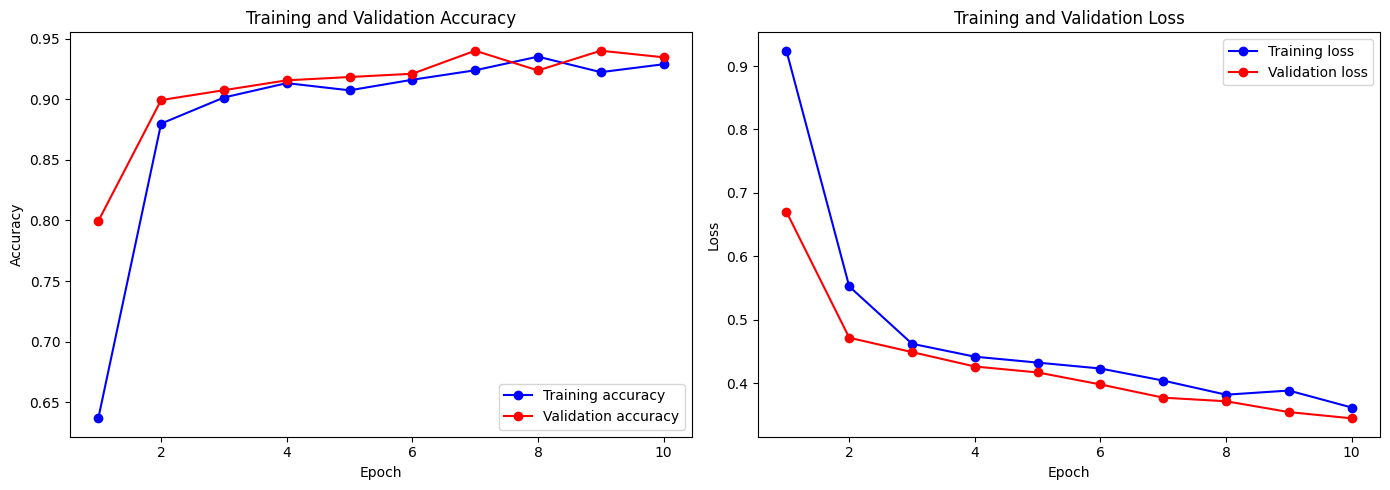

/media/X/Research_coffee_classification/.venv/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step
Confusion Matrix


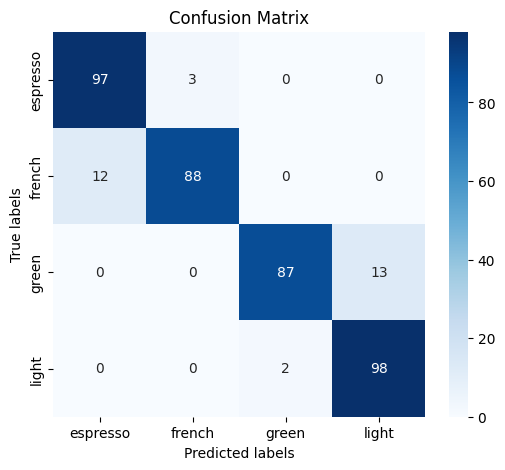

13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
Classification Reports
              precision    recall  f1-score   support

    espresso       0.89      0.97      0.93       100
      french       0.97      0.88      0.92       100
       green       0.98      0.87      0.92       100
       light       0.88      0.98      0.93       100

    accuracy                           0.93       400
   macro avg       0.93      0.93      0.92       400
weighted avg       0.93      0.93      0.92       400

13/13 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.9347 - loss: 0.4101
Test Accuracy: 0.925000011920929
Test Loss: 0.3770885765552521
13/13 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step


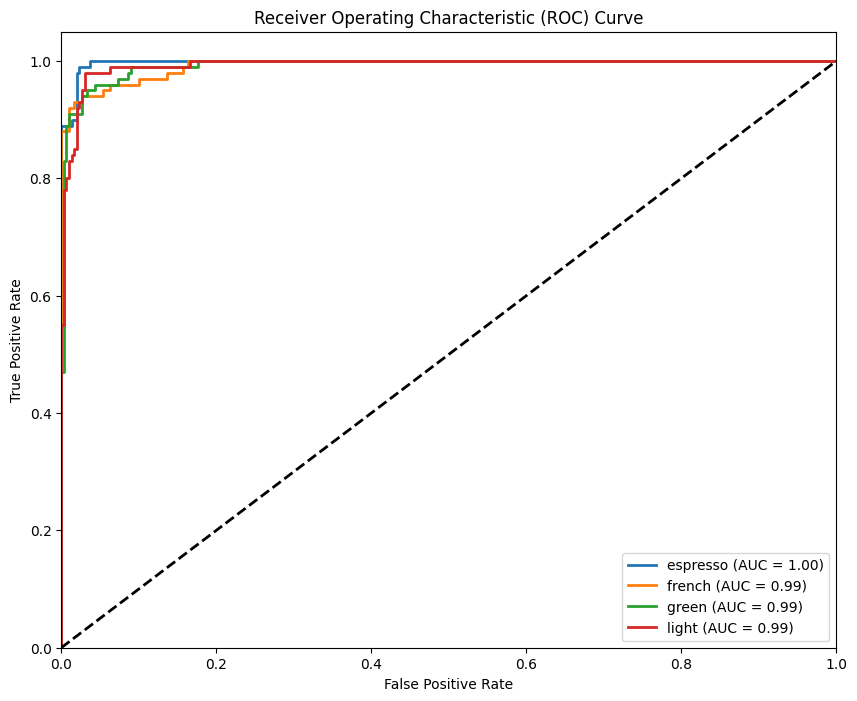

13/13 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step
Misclassifications


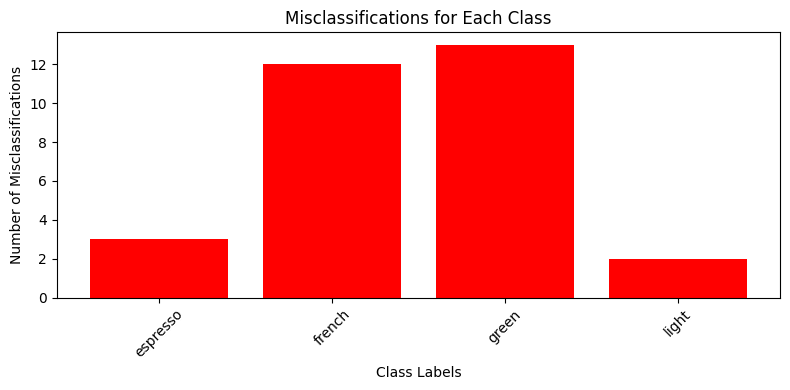

In [10]:
all_measurement(history,model,test_generator)

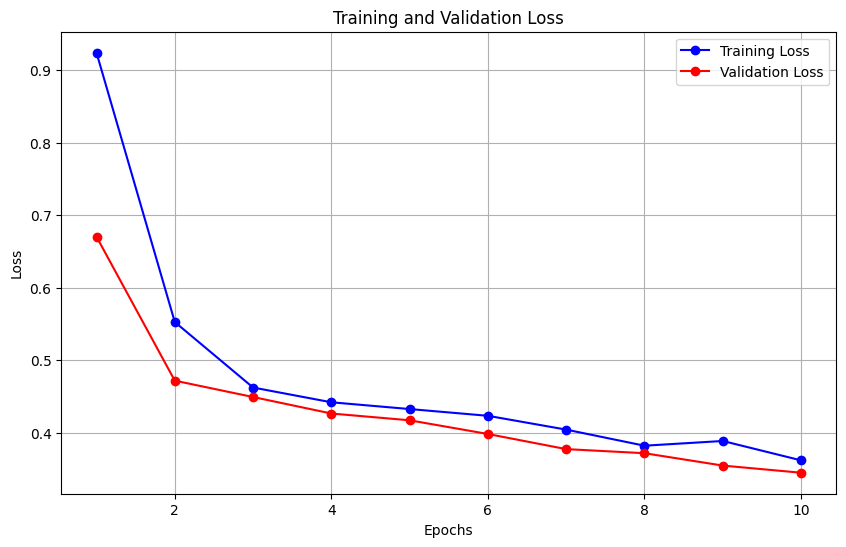

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, 'bo-', label='Training Loss')
plt.plot(epochs, val_loss, 'ro-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()